In [37]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments of MLP and its sparse variants


- Initial MLP
- MLP with BIBD
- Random sparse MLP

## A bit setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.3.1  Device: cuda


## `Mlp`, `BibdMlp`, `RandomSparseMlp` on MNIST dataset

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [4]:
from models import Mlp, BibdMlp, RandomSparseMlp


input_dim = 28 * 28 * 1
output_dim = 10

model_list = []
if torch.cuda.is_available():
#     model_list.append(torch.nn.DataParallel(Mlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(BibdMlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(RandomSparseMlp(input_dim, output_dim).to(device)))
    model_list.append(Mlp(input_dim, output_dim).to(device))
    model_list.append(BibdMlp(input_dim, output_dim).to(device))
    model_list.append(RandomSparseMlp(input_dim, output_dim).to(device))
for model in model_list:
    print(model)

Mlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=49, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
BibdMlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (bibd2): BibdLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
RandomSparseMlp(
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (randomSparseLinear2): RandomSparseLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)


Using PyTorch version: 1.3.1  Device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303215
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.022330
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.626801
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.470041

Validation set: Average loss: 0.3334, Accuracy: 9034/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.364453
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.725208
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.529634
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.400862

Validation set: Average loss: 0.2426, Accuracy: 9273/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.314965
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.147083
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.220584
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.226074

Validation set: Average loss: 0.2006, Accuracy: 9379/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.680767
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.274562
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.091753
Train Epoch: 4 [48000/6000

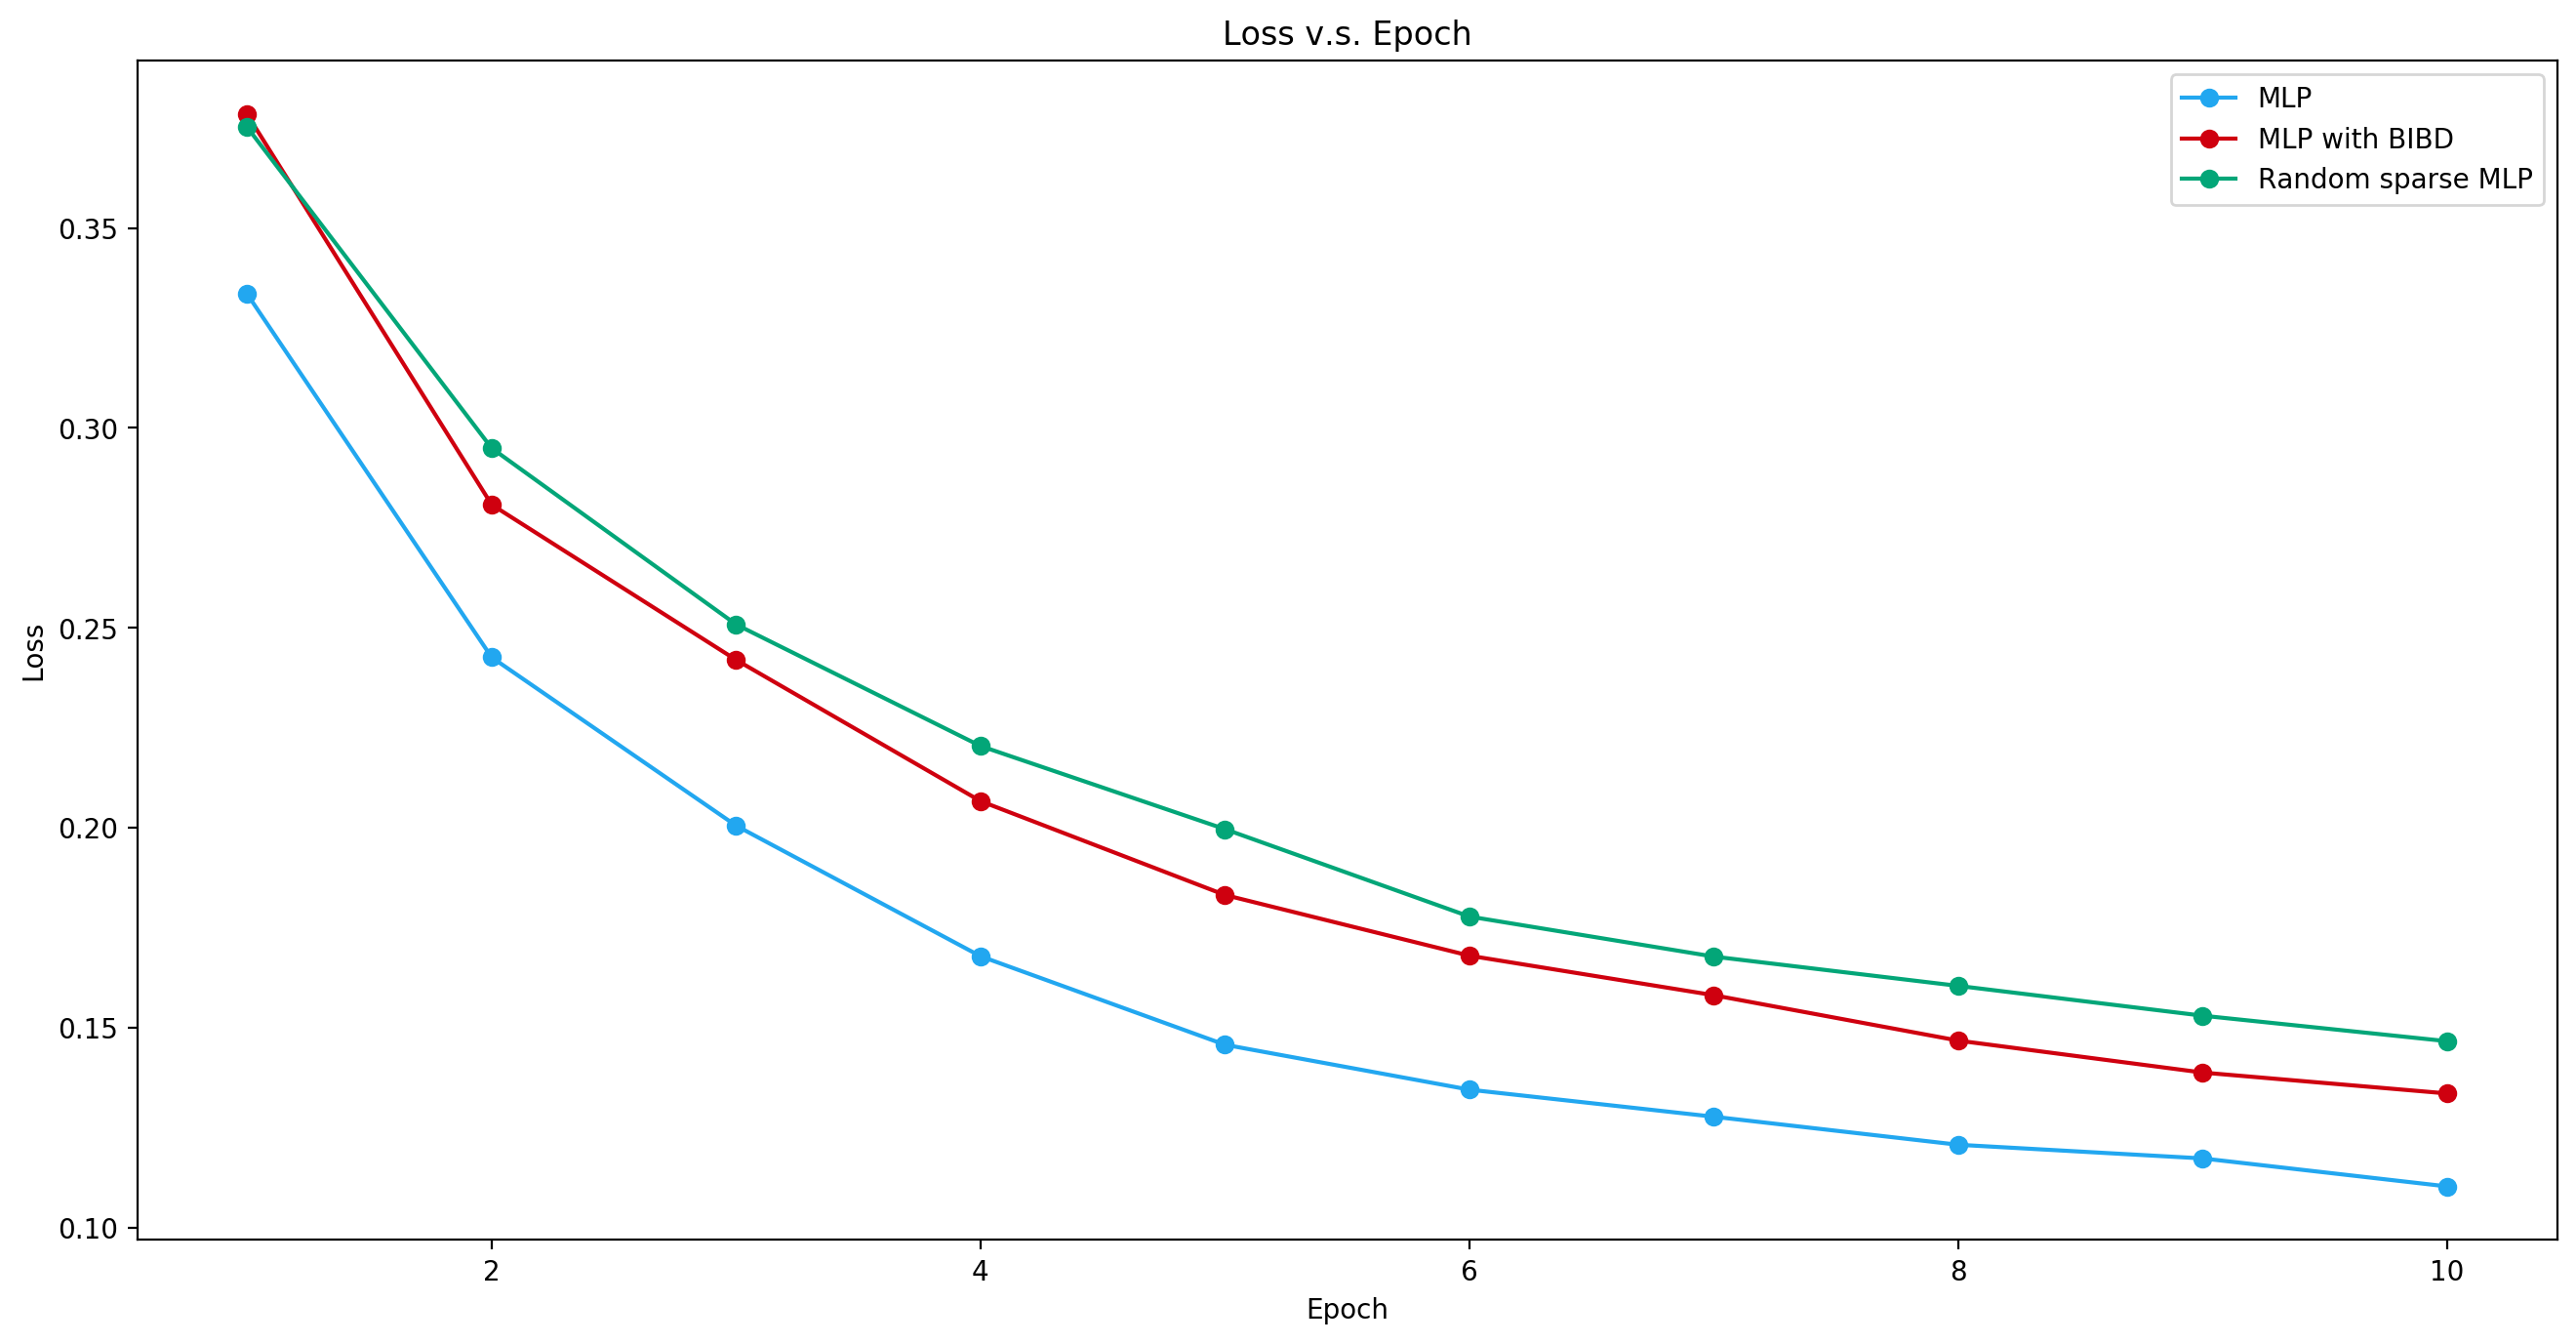

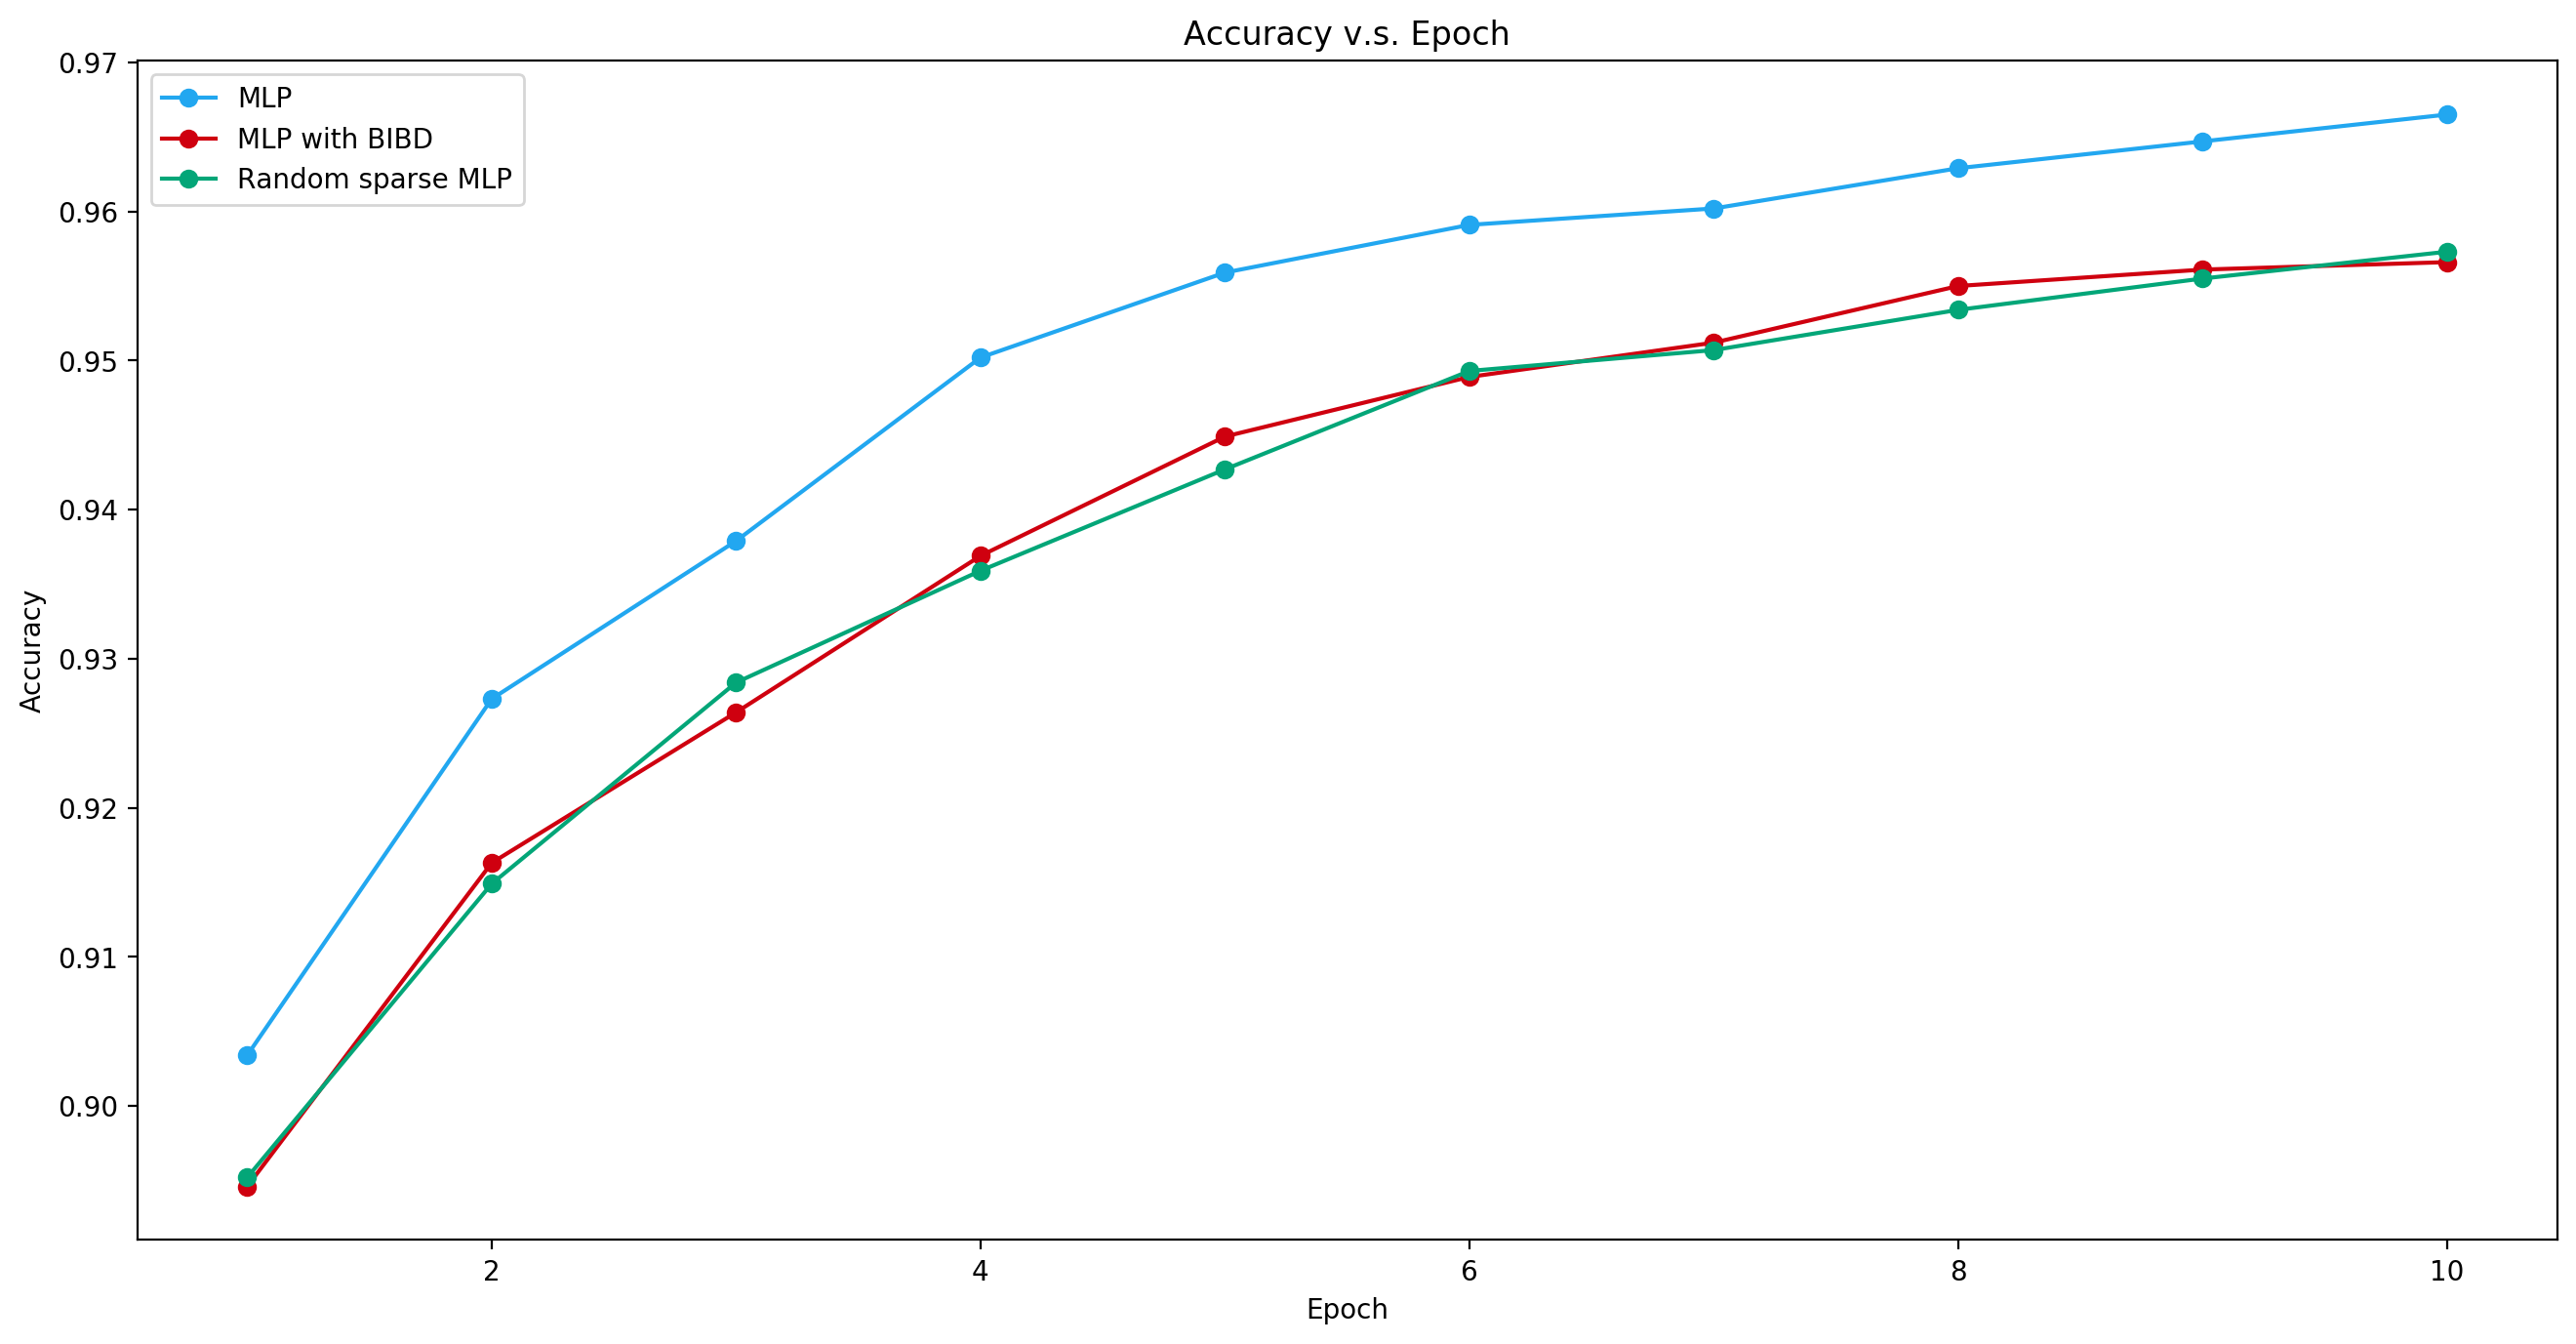

In [5]:
%%time


from experiment import Experiment


experiment = Experiment(n_epoch=10)
for model in model_list:
    experiment.run_model(model, train_loader, validation_loader)
experiment.plot()

In [24]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

time_str = '1m43s'
length = len(model.name) + len(time_str) + 23 + 4
print('=' * length)
print('  ' + bcolors.OKGREEN + bcolors.BOLD + 'Time usage for model ' + bcolors.UNDERLINE + bcolors.OKBLUE + model.name + bcolors.ENDC + ': ' + time_str + '  ')
print('=' * length)

  Time usage for model Random sparse MLP: 1m43s  


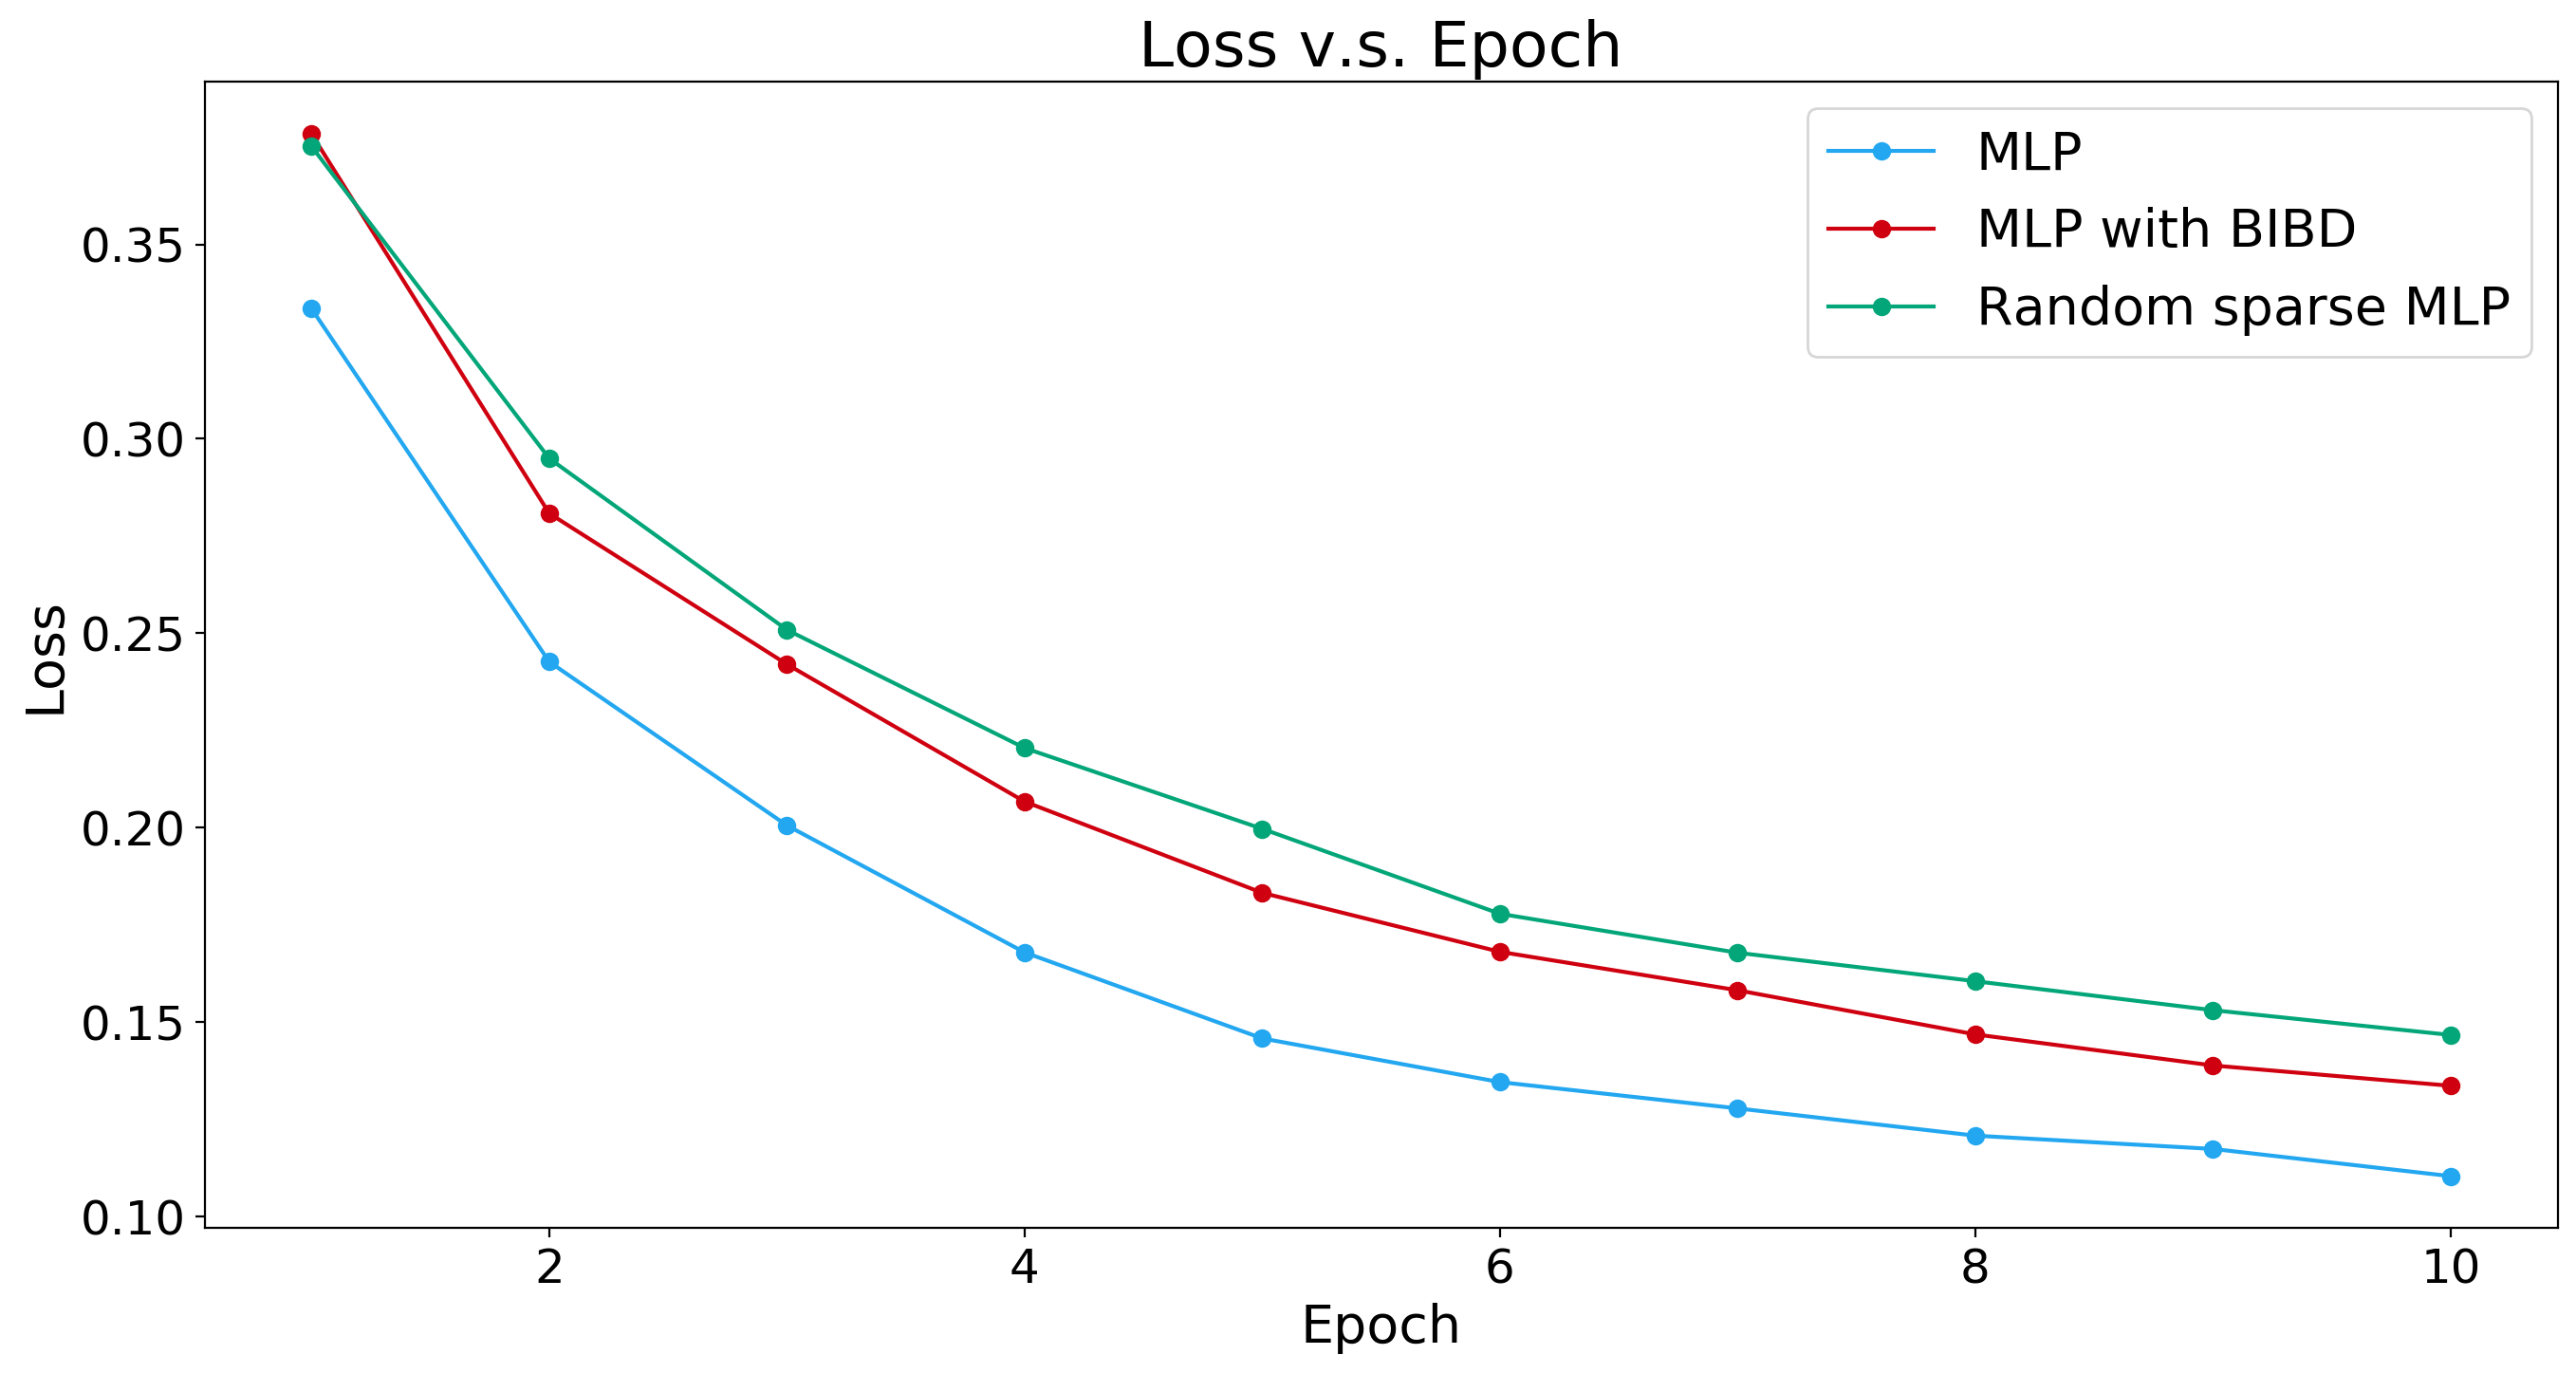

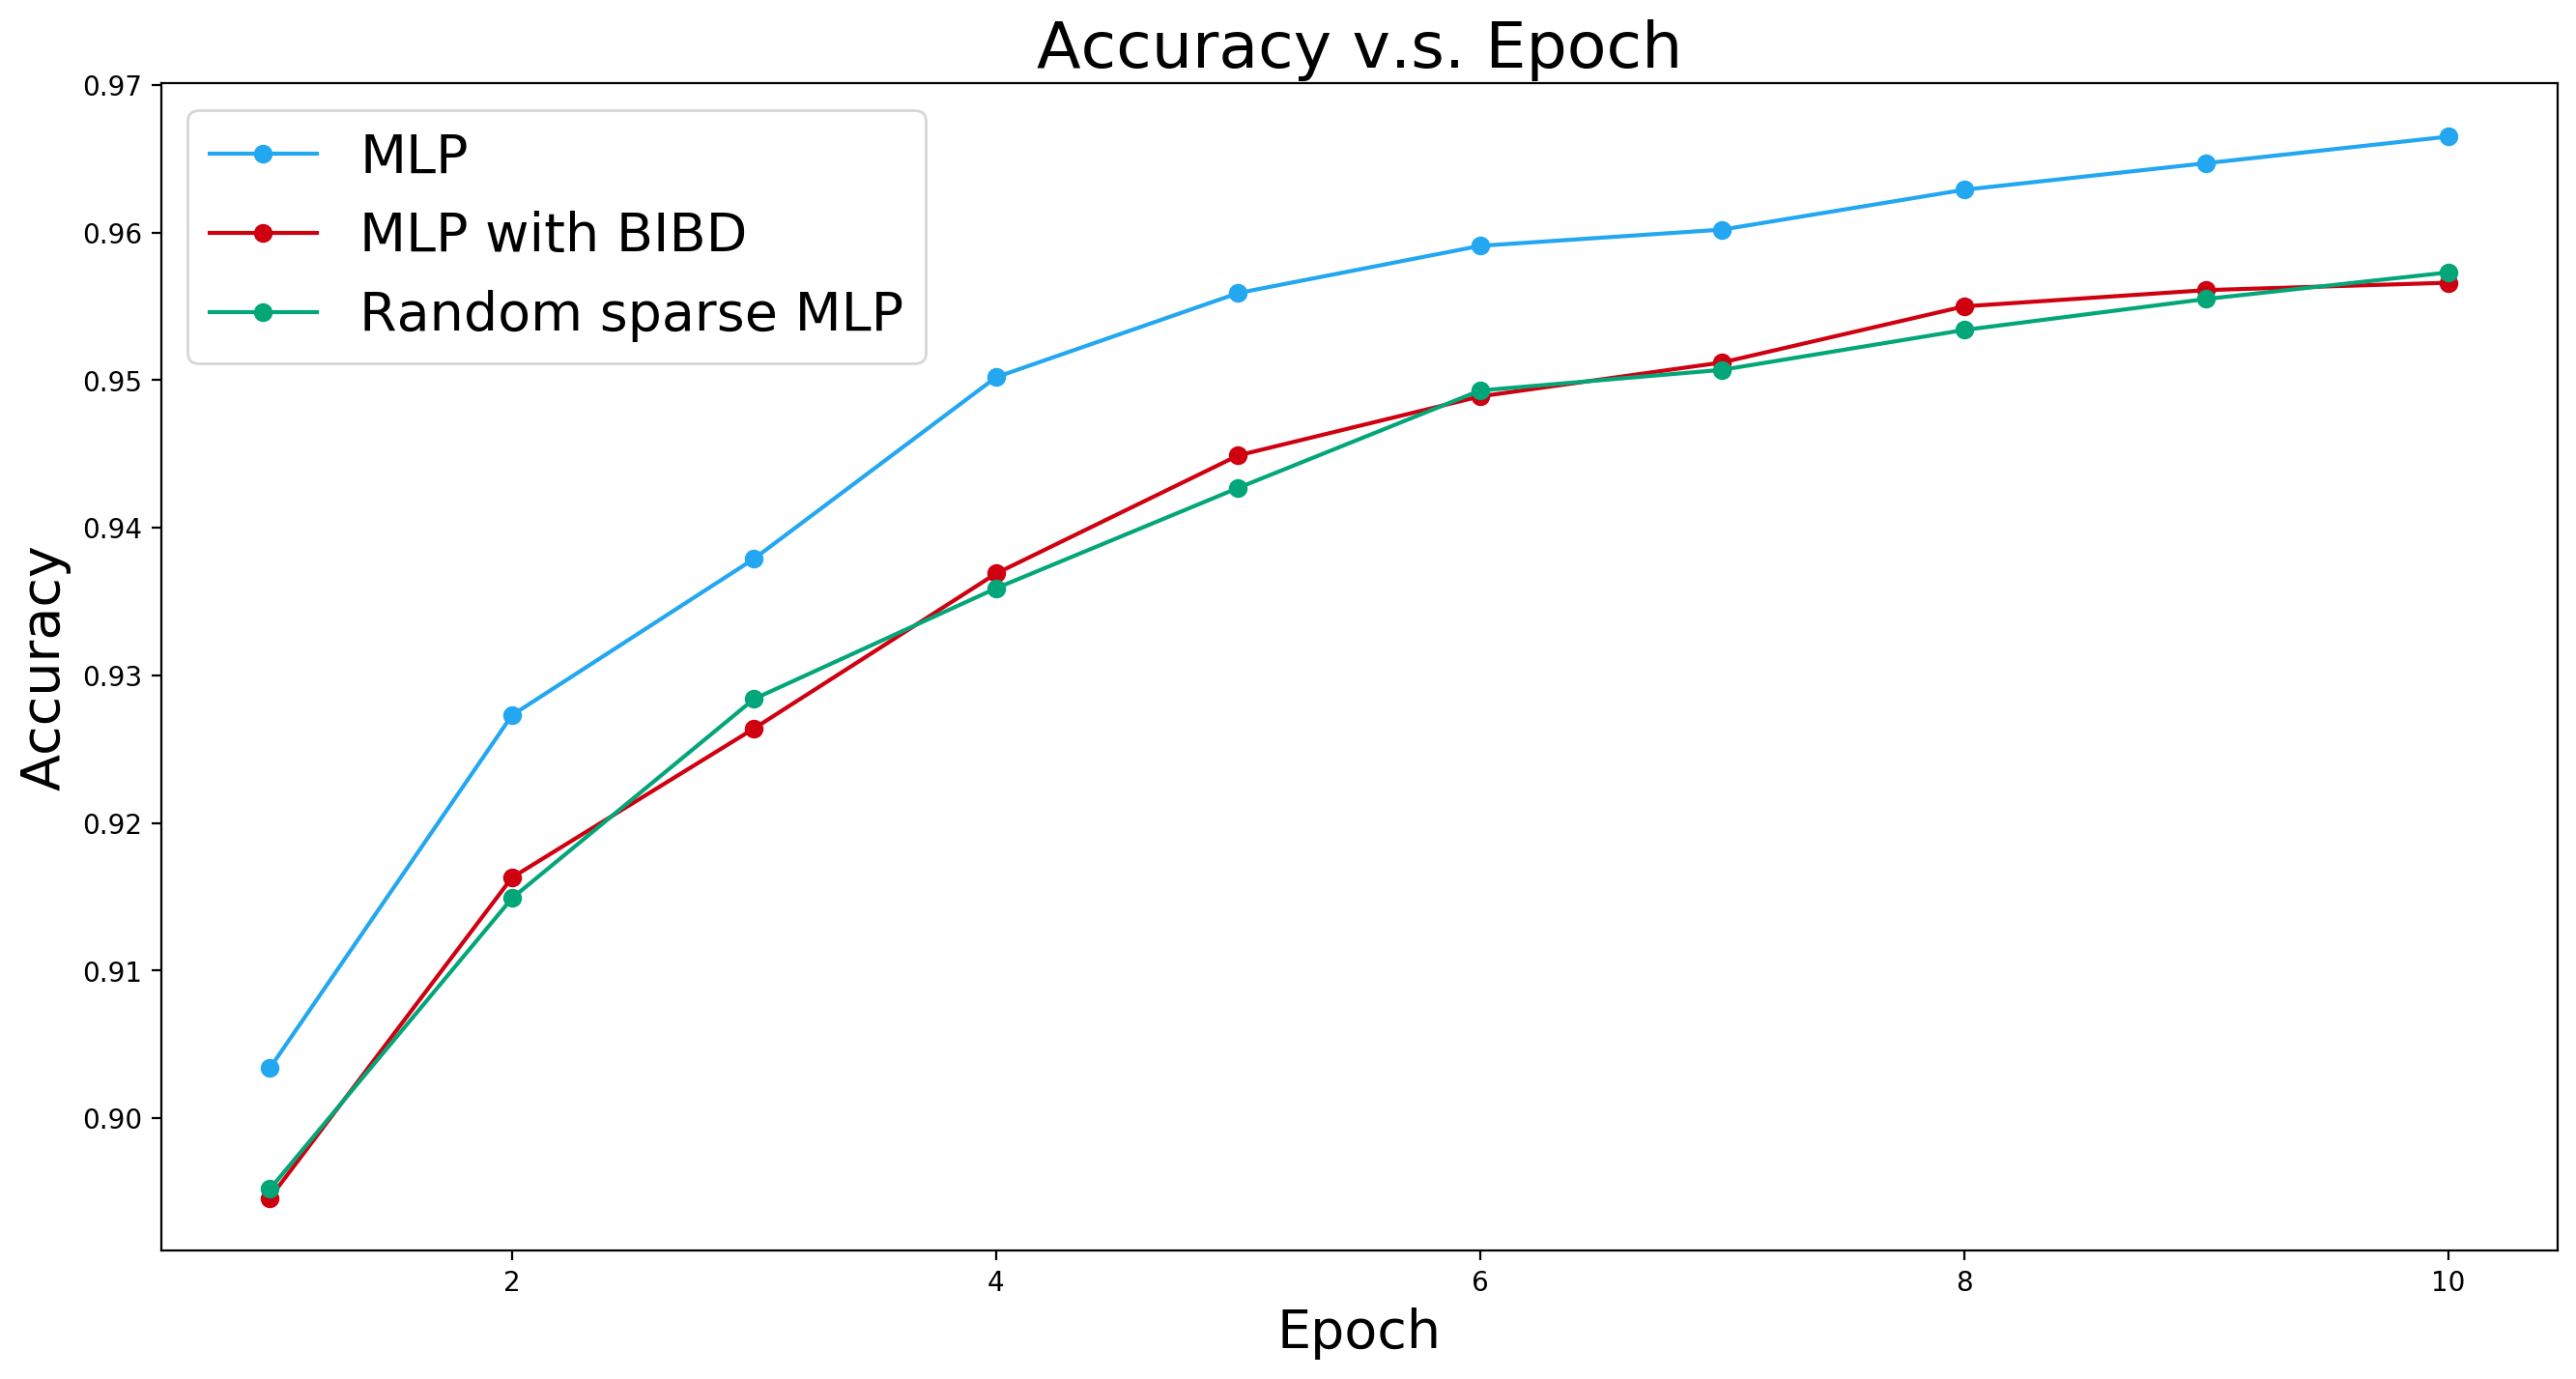

In [46]:
fig_loss, fig_acc = experiment.plot()

In [47]:
import matplotlib.pyplot as plt


fig_loss.set_size_inches((16, 12))
fig_loss.set_dpi(100)

plt.tight_layout()

fig_loss.savefig('fig_loss.eps', format='eps', pad_inches=0)

fig_loss.savefig('fig_loss.svg', format='svg')


fig_loss.savefig('fig_loss.png', format='png', pad_inches=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>